# CLTV PREDICTION WITH BG/NBD AND GAMMA&GAMMA MODELS

### What is CLTV (Customer Life Time Value)?

Customer lifetime value (CLTV), represents the total amount of money a customer is expected to spend in your business, or on your products, during their lifetime. 

Focusing on CLTV helps you design an efficient strategy with concise budget planning. However, some customers bring your business more value than the others. That’s why it’s crucial to know which ones you should focus on first and invest in.

With CLTV calculation, you can take a picture of today, but with CLTV prediction, you make time projections such as 3 months, 1 year.

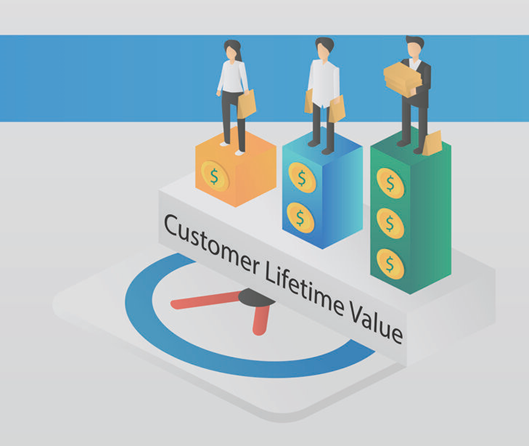


**BG/NBD (Beta Geometric / Negative Binomial Distribution) Model** will model each customer’s purchase behaviours’ distribution and will predict the expected number of transactions for each customer. It is also known as “Buy Till You Die” Model. 

BG/NBD model, models 2 processes as 

* **Transaction Process (Buy)**  
    * During the customer is alive, the number of will have made by the customer, will be distributed poison by transaction rate parameter
    * During the customer is alive, they will be purchasing around their own transaction rate
    * Transaction rates will change for each customer and they will be distributed gamma (r,α)
    
    
* **Dropout Process (Till You Die)**
    * Each customer has their own dropout rate by p probability
    * The customer will be a dropout by p probability
    * Dropout rates will change for each customer and they will be distributed beta (a,b) for the mass
    
    

**Gamma-Gamma Submodel** will model the expected average profit distribution and will predict the expected average profit for each customer.

**Context**

The dataset named Online Retail II was obtained from a UK-based online store and includes sales from 01/12/2009 to 09/12/2011.

This company sells souvenirs and most of their customers are also wholesalers. Within the scope of this study, only 2010-2011 sales will be consedered.

**Business Problem**

Our aim is to identify the customers who can generate the most revenue within the 6-month time period.

**Task Details**

1. Importing Libraries and Data
2. Data Preprocessing
3. Preparation of CLTV Data Structure
4. Establishing the BG-NBD Model
5. Establishing the Gamma Gamma Model
6. Calculation of CLTV with BG-NBD and GG model.


**Attribute Information:**

**InvoiceNo:** Invoice number. The unique number of each transaction, that is, the invoice. Aborted operation if it starts with C.

**StockCode:** Product code. Unique number for each product.

**Description:** Product name

**Quantity:** Number of products. It expresses how many of the products on the invoices have been sold.

**InvoiceDate:** Invoice date and time.

**UnitPrice:** Product price (in GBP)

**CustomerID:** Unique customer number

**Country:** Country name. Country where the customer lives.

## 1. IMPORTING LIBRARIES AND DATA

In [1]:
!pip install openpyxl
!pip install lifetimes
import datetime as dt
import pandas as pd
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

     |████████████████████████████████| 242 kB 288 kB/s            
     |████████████████████████████████| 584 kB 288 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=b00e0289b00a7db7ab99c8cb4330609477e7754e7f67229ad75d1a3a3e970282
  Stored in directory: /root/.cache/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd


In [2]:
df = pd.read_excel("../input/uci-online-retail-ii-data-set/online_retail_II.xlsx",sheet_name="Year 2010-2011")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


## 2.DATA PREPROCESSING

This study will be conducted for UK customers only.

In [3]:
df=df[df["Country"]=="United Kingdom"]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,495478.00,8.61,227.59,-80995.00,1.00,3.00,10.00,80995.00
Price,495478.00,4.53,99.32,-11062.06,1.25,2.10,4.13,38970.00
Customer ID,361878.00,15547.87,1594.40,12346.00,14194.00,15514.00,16931.00,18287.00


It can be seen that there are negative values in the Quantity and Price columns. These transactions are canceled orders. These observations needed to be eliminated.

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    133600
Country             0
dtype: int64

There are null values in the dataset, we need to remove these observations from the dataset. 

In [5]:
df.dropna(inplace=True)

In [6]:

df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [7]:
df.describe([0.01,0.25,0.50,0.75,0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Quantity,354321.00,12.01,189.27,1.00,1.00,2.00,4.00,12.00,100.00,80995.00
Price,354321.00,2.96,17.86,0.00,0.21,1.25,1.95,3.75,12.75,8142.75
Customer ID,354321.00,15552.49,1594.53,12346.00,12748.00,14194.00,15522.00,16931.00,18223.00,18287.00


According to the values at 99% quantile of Quantity and Price columns and the maximum values,it can be said that there are some outliers.

In order to find out these outliers and replace them with the treshold values, we will use the functions of "outlier_tresholds" and "replace_with_tresholds".

In [8]:

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [9]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

## 3. PREPARATION OF CLTV DATA STUCTURE

In [10]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.00,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34


In [11]:
df.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

as today's date it will be taken 2 days after the last date in the dataset

In [12]:
today_date = dt.datetime(2011, 12, 11)

**recency:** The time from the customer's first purchase to their last purchase. Weekly. (ATTENTION: In RFM Analysis, recency represents the time elapsed from the date of the last purchase to the date of evaluation)

**T:** The age of the customer. Weekly. (how long before the analysis date the first purchase was made)

**frequency:** total number of repeat purchases (frequency>1)

**monetary_value:** average earnings per purchase

In [13]:
cltv_df=df.groupby("Customer ID").agg(({"InvoiceDate":[lambda x:(x.max()-x.min()).days,
        lambda x:(today_date-x.min()).days],
        "Invoice":lambda x:x.nunique(),
        "TotalPrice":lambda x:x.sum()}))
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.00              0        326        1     258.44
12747.00            366        370       11    4196.01
12748.00            372        374      209   32303.91
12749.00            209        214        5    4072.44
12820.00            323        327        4     942.34

In [14]:
cltv_df.columns = cltv_df.columns.droplevel(0)
## naming the features
cltv_df.columns=["Recency","T","Frequency","Monetary"]
cltv_df.head()

,Recency,T,Frequency,Monetary
Customer ID,,,,
12346.00,0,326,1,258.44
12747.00,366,370,11,4196.01
12748.00,372,374,209,32303.91
12749.00,209,214,5,4072.44
12820.00,323,327,4,942.34


Total price per transaction need to be calculated.

In [15]:
cltv_df["Monetary"]=cltv_df["Monetary"] / cltv_df["Frequency"]
cltv_df.head()

,Recency,T,Frequency,Monetary
Customer ID,,,,
12346.00,0,326,1,258.44
12747.00,366,370,11,381.46
12748.00,372,374,209,154.56
12749.00,209,214,5,814.49
12820.00,323,327,4,235.59


Selection of monetary values greater than zero

In [16]:
cltv_df=cltv_df[cltv_df["Monetary"]>0]

Expression of recency and T for BG/NBD in weekly terms

In [17]:
cltv_df["Recency"]=cltv_df["Recency"]/7
cltv_df["T"]=cltv_df["T"]/7


Frequency must be greater than 1.

In [18]:
cltv_df= cltv_df[cltv_df["Frequency"]>1]
cltv_df.head()

,Recency,T,Frequency,Monetary
Customer ID,,,,
12747.00,52.29,52.86,11,381.46
12748.00,53.14,53.43,209,154.56
12749.00,29.86,30.57,5,814.49
12820.00,46.14,46.71,4,235.59
12822.00,2.29,12.57,2,474.44


## 4. ESTABLISHING THE BG/NBD MODEL

In [19]:
bgf=BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["Frequency"],cltv_df["Recency"],cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.66, b: 2.51, r: 2.21>

In [20]:
bgf.conditional_expected_number_of_purchases_up_to_time(24,
                                                        cltv_df['Frequency'],
                                                        cltv_df['Recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
12748.00   76.28
17841.00   45.55
13089.00   36.09
14606.00   34.37
15311.00   33.66
12971.00   31.86
13408.00   23.16
18102.00   22.74
13798.00   21.40
14527.00   20.80
dtype: float64

Top 10 customers expected to make the most purchases in next 6 months

## 5. ESTABLISHING THE GAMMA&GAMMA MODEL

In [21]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['Frequency'], cltv_df['Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 3.82, q: 0.35, v: 3.75>

In [22]:
ggf.conditional_expected_average_profit(cltv_df["Frequency"],
                                        cltv_df['Monetary']).sort_values(ascending=False).head(10)

Customer ID
14088.00   3911.32
18102.00   3595.19
14096.00   3191.39
17511.00   2938.27
15749.00   2675.12
17450.00   2639.42
13081.00   2616.63
16984.00   2452.13
16000.00   2181.33
16684.00   2133.20
dtype: float64

In [23]:
cltv_df["Expected_average_profit_per_transaction"] = ggf.conditional_expected_average_profit(cltv_df['Frequency'],
                                                                             cltv_df['Monetary'])  

In [24]:
cltv_df.sort_values("Expected_average_profit_per_transaction", ascending=False).head(10)

,Recency,T,Frequency,Monetary,Expected_average_profit_per_transaction
Customer ID,,,,,
14088.00,44.57,46.14,13,3859.60,3911.32
18102.00,52.29,52.57,60,3584.89,3595.19
14096.00,13.86,14.57,17,3159.08,3191.39
17511.00,52.86,53.43,31,2921.95,2938.27
15749.00,13.86,47.57,3,2521.45,2675.12
17450.00,51.29,52.57,46,2629.53,2639.42
13081.00,51.29,53.14,11,2575.62,2616.63
16984.00,5.86,18.71,2,2240.68,2452.13
16000.00,0.00,0.43,3,2055.79,2181.33


These are the top 10 customers expected to have highest Expected_average_profit_per_transaction

## 6. CALCULATION OF CLTV WITH BG/NBD AND GAMMA&GAMMA MODEL

The CLTV values expected in the next 6 months

In [25]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['Frequency'],
                                   cltv_df['Recency'],
                                   cltv_df['T'],
                                   cltv_df['Monetary'],
                                   time=6,  # 6 Months
                                   freq="W",  # Week
                                   discount_rate=0.01)

cltv.head()

Customer ID
12747.00    1937.01
12748.00   12366.07
12749.00    3445.92
12820.00     631.93
12822.00    1612.13
Name: clv, dtype: float64

In [26]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

,Customer ID,clv
2486,18102.00,85648.50
589,14096.00,55646.83
2184,17450.00,48531.95
2213,17511.00,36796.03
1804,16684.00,25082.35
406,13694.00,25060.00
587,14088.00,25009.46
1173,15311.00,23590.68
133,13089.00,22927.00
1057,15061.00,21122.49
